In [1]:
import cv2
import imutils
from PIL import Image
import pytesseract
import numpy as np

In [2]:
import mod.download as dl

filing_df = dl.clerk_filings("Pelosi")
df_filtered = filing_df[filing_df["Filing"] == "FD Original"][:3]
df_filtered = df_filtered.assign(images=df_filtered["href"].apply(lambda x: dl.image_from_endpoint(x)))

In [3]:
metadata, images = df_filtered["images"].iloc[2]
first_page = images[0]
form_opencv = cv2.cvtColor(np.array(first_page), cv2.COLOR_RGB2BGR)

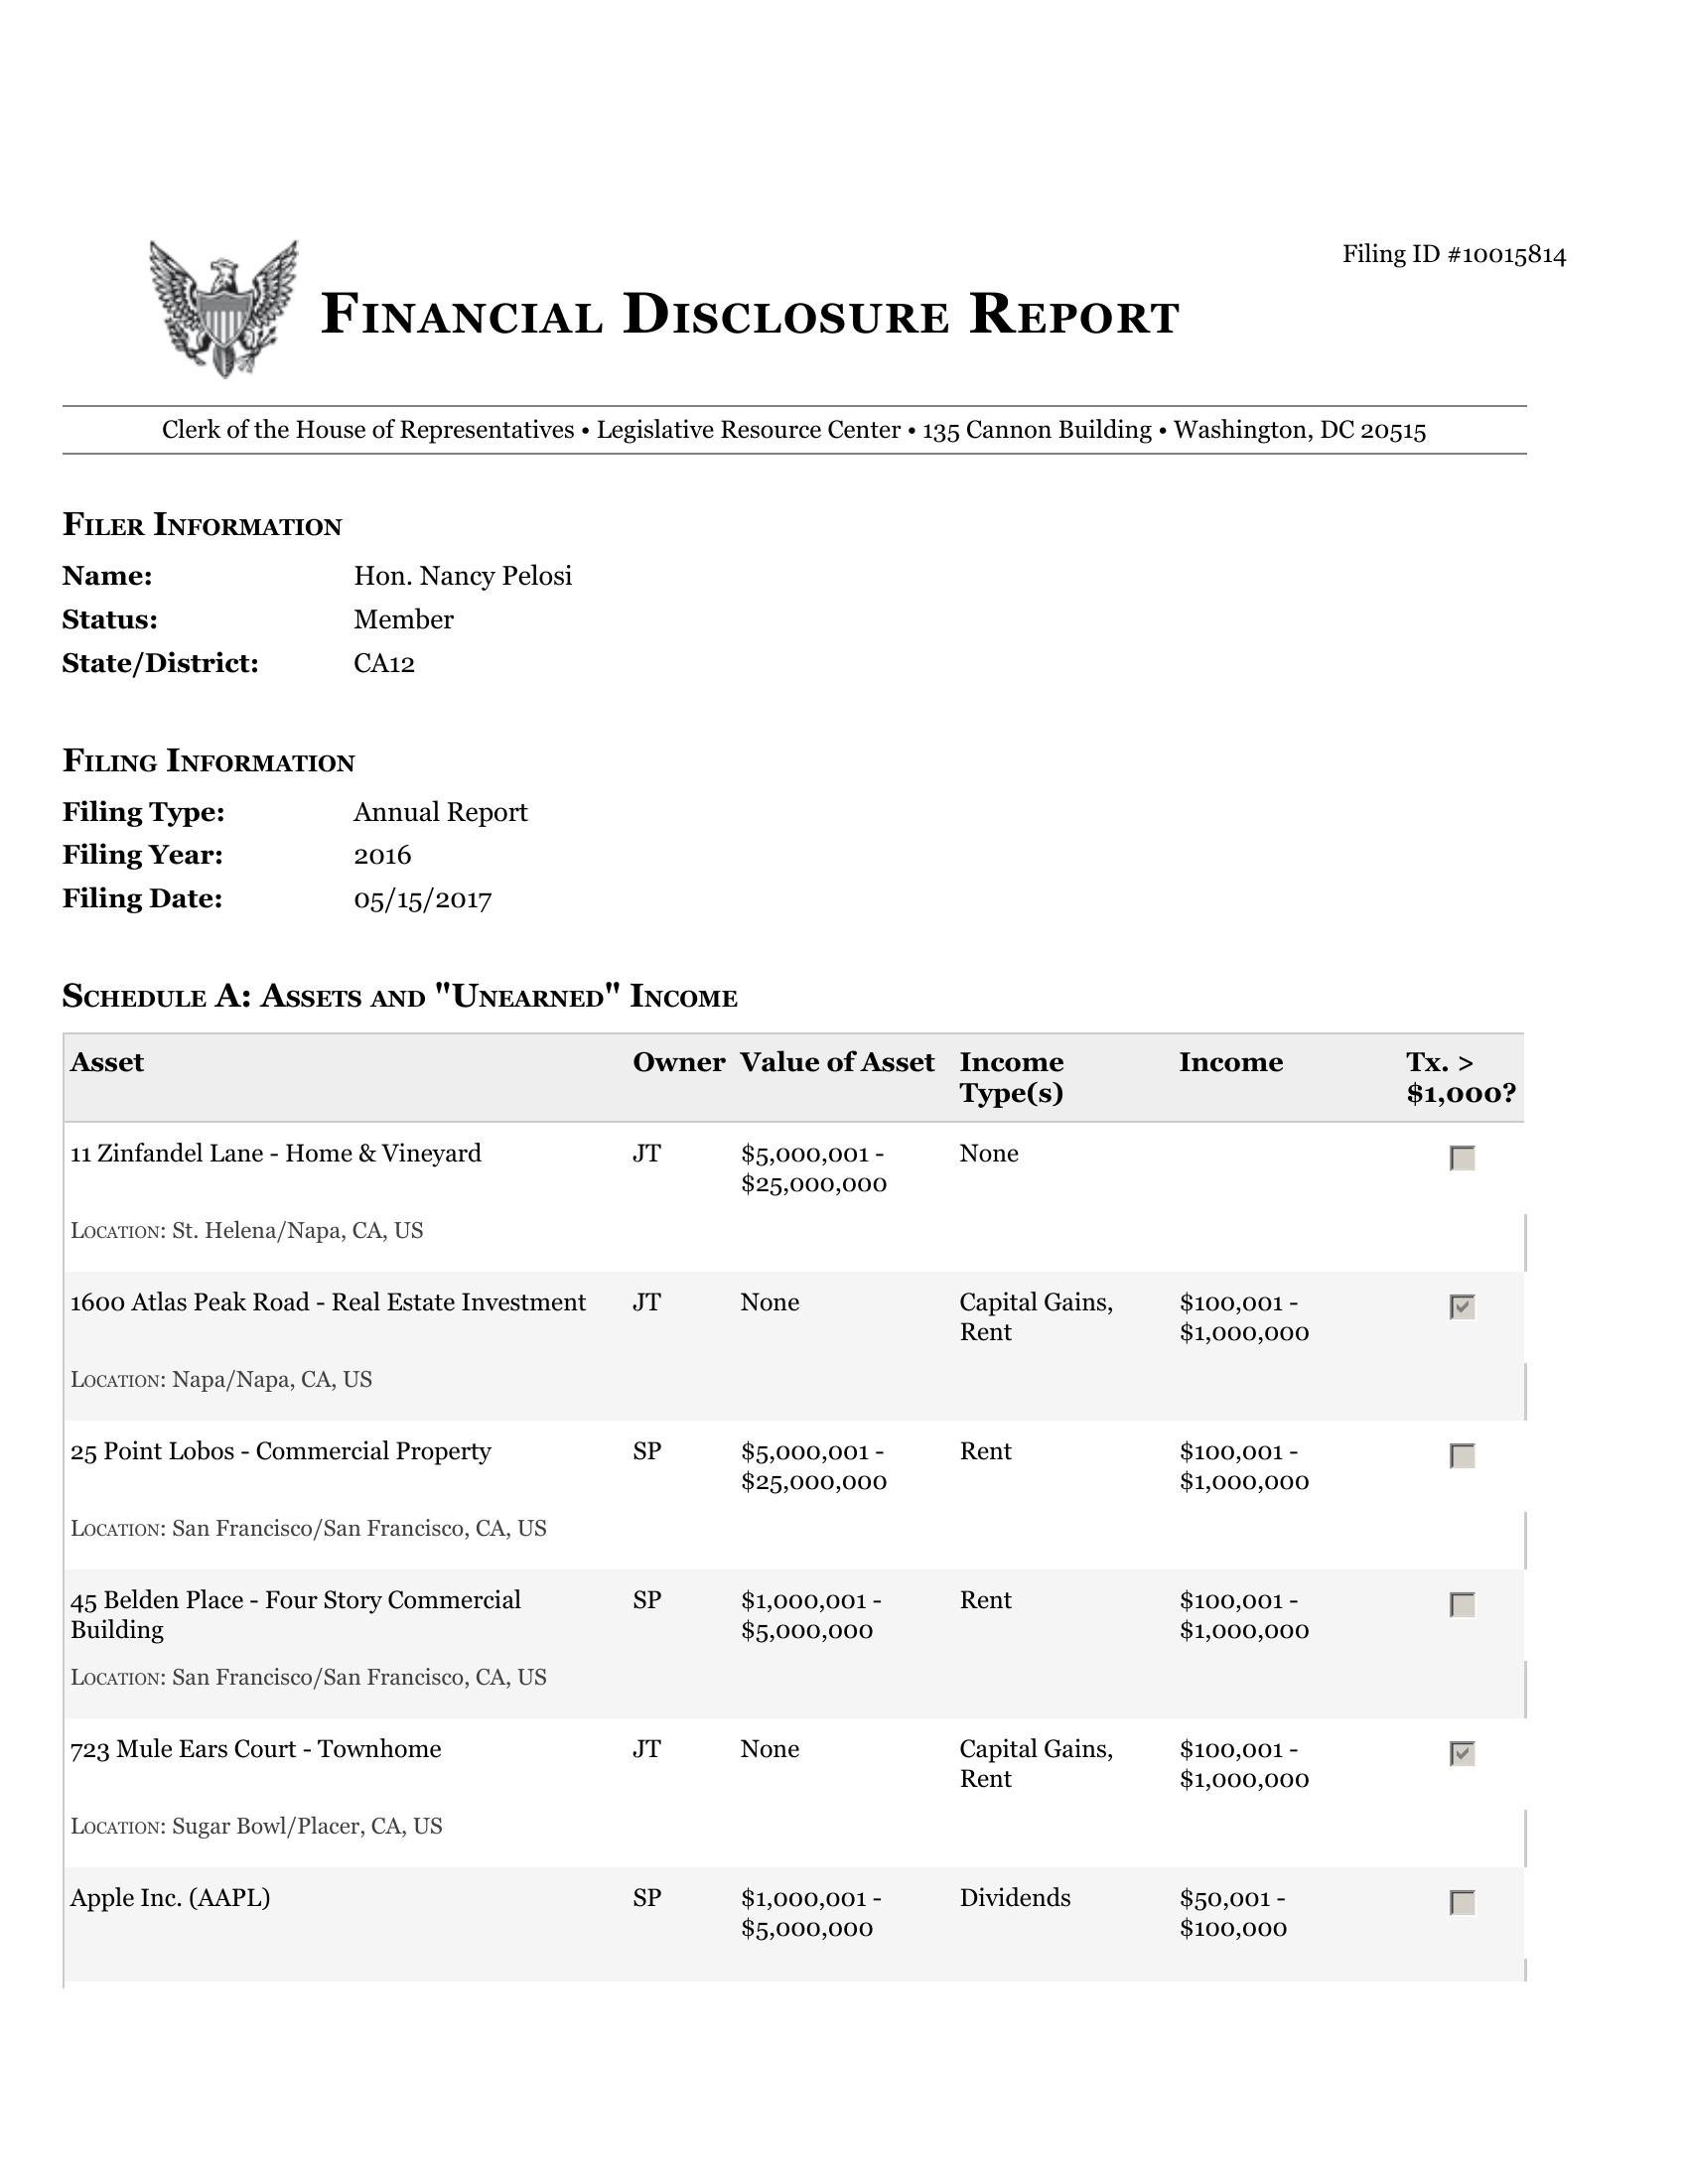

In [4]:
first_page

In [5]:
# for quickly saving images for inspection
def si(array, path="../outputs/tmp/temp.png"):
    Image.fromarray(array).save(path)

In [6]:
def list_contour_coords(thresh_img, sortkey=None, reverse=True):
    border_contours_obj = cv2.findContours(thresh_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    border_contours = imutils.grab_contours(border_contours_obj)
    contour_list = list(border_contours)
    if sortkey:
        contour_list.sort(reverse=reverse, key=sortkey)
    contour_list_coords = [cv2.boundingRect(x) for x in contour_list]
    return contour_list_coords

def apply_mask(img, coords):
    (x, y, w, h) = coords
    masked_img = img[y:y + h, x:x + w]
    return masked_img

In [7]:
gray_img = cv2.cvtColor(form_opencv, cv2.COLOR_BGR2GRAY)
(thresh, thresh_img) = cv2.threshold(gray_img, 250, 255, cv2.THRESH_BINARY_INV)
largest_contour = list_contour_coords(thresh_img, cv2.contourArea)[0]
form_cropped = apply_mask(thresh_img, largest_contour)
img_cropped = apply_mask(form_opencv, largest_contour)

In [8]:
form_open = cv2.morphologyEx(form_cropped, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (30,30)))
form_close = cv2.morphologyEx(form_open, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (20,20)))
si(form_close)

In [9]:
def get_rows(morphed_form):
    sortkey = lambda x: cv2.boundingRect(x)[1]
    row_contours = list_contour_coords(morphed_form)
    inv_contours = list_contour_coords(cv2.bitwise_not(morphed_form))
    row_contours.extend(inv_contours)
    row_contours.sort(key=lambda x: x[1])
    header = row_contours.pop(0)
    return {"header": header, "rows": row_contours}

In [10]:
row_coords = get_rows(form_close)
rows = []
for elem in row_coords["rows"]:
    row = apply_mask(img_cropped, elem)
    rows.append(row)
header = apply_mask(img_cropped, row_coords["header"])

In [11]:
row_copy = rows.copy()
(thresh_row, thresh_img_row) = cv2.threshold(row_copy[0], 160, 255, cv2.THRESH_BINARY)
si(thresh_img_row)

In [12]:
row_text = []
for idx, row in enumerate(rows):
    (thresh, thresh_img) = cv2.threshold(row, 160, 255, cv2.THRESH_BINARY)
    text_data = pytesseract.image_to_data(
        thresh_img,
        config="--psm 11",
        output_type=pytesseract.Output.DICT
    )
    row_text.append((idx, text_data))

In [13]:
def filter_coords(t_dict, thresh):
    zipped_coords = zip(t_dict["left"], t_dict["top"], t_dict["width"], t_dict["height"])
    zipped_conf = zip(t_dict["conf"], zipped_coords)
    filtered_coords = []
    for idx, v in enumerate(zipped_conf):
        (conf, coords) = v
        if conf > thresh:
            filtered_coords.append((idx, coords))
        else:
            continue
    return filtered_coords

def fill_word_with_points(word_coords, point_spacing):
    points = []
    i = 0
    for (ind, fcoord) in filtered_coords:
        (x, y, w, h) =  fcoord
        centre_points = [(ind, (x, y + h/2)) for x in np.arange(x, x + w, point_spacing)]
        centre_points.append((ind, (x + w, y + h/2)))
        points.extend(centre_points)
    return points

In [14]:
point_spacing = 30
row_points = []
for idx, tdata in row_text:
    filtered_coords = filter_coords(tdata, 2)
    word_points = fill_word_with_points(filtered_coords, point_spacing)
    point_cds = [np.array([x, y]) for (_,(x,y)) in word_points]
    a = rows[idx].copy()
    row_points.append(word_points)
    for (x, y) in point_cds:
        cv2.circle(a, (int(x), int(y)), 0, (0,0,255), 5)
    si(a, f"../outputs/tmp/{idx}.png")

In [15]:
from sklearn.cluster import AgglomerativeClustering
from itertools import groupby

clustering = AgglomerativeClustering(
    distance_threshold=31,
    affinity="euclidean",
    linkage="single",
    n_clusters=None
)
coords = [(x, y) for (_, (x, y)) in row_points[0]]
cluster_mapped = clustering.fit_predict(coords)
groupingkey = lambda x: x[0]
zipped_labels = list(zip(cluster_mapped, row_points[0]))
zipped_labels.sort(key=groupingkey)
cluster_groups = groupby(zipped_labels, groupingkey)
cluster_dict = {
    k: list(map(lambda x: x[1], v)) for k, v in cluster_groups
}
for k, v in cluster_dict.items():
    print(f"{k}: {len(v)} elems in cluster")

0: 3 elems in cluster
1: 14 elems in cluster
2: 2 elems in cluster
3: 18 elems in cluster
4: 23 elems in cluster


In [57]:
word_clusters = []
d = row_text[0][1]
for (cluster, coord) in zipped_labels:
    index = coord[0]
    word_clusters.append((cluster, index))
    
clusters_indices = list(set(word_clusters))
clusters_words = []
for idx, text in enumerate(d['text']):
    for cluster, t_idx in clusters_indices:
        if t_idx == idx:
            clusters_words.append((cluster, text))
            break
clusters_coords = [
    (cluster, (d['left'][i], d['top'][i], d['width'][i], d['height'][i]))
     for (cluster, i)
     in clusters_indices
]

In [58]:
clusters_words

[(4, '11'),
 (4, 'Zinfandel'),
 (4, 'Lane'),
 (4, '—'),
 (4, 'Home'),
 (4, '&'),
 (4, 'Vineyard'),
 (2, 'JT'),
 (1, '$5,000,001'),
 (1, '—'),
 (0, 'None'),
 (1, '$25,000,000'),
 (3, 'Location:'),
 (3, 'St.'),
 (3, 'Helena/Napa,'),
 (3, 'CA,'),
 (3, 'US')]

In [33]:
copyrow = thresh_img_row.copy()
for (cluster, coord) in clusters_coords:
    np.random.seed(cluster)
    color = [int(c) for c in np.random.randint(0, 255, size=(3,), dtype="int")]
    (x,y,w,h) = coord
    cv2.rectangle(copyrow, (x, y), (x+w, y+h), color, 3)

        
si(copyrow)        

In [52]:
clusters_words

[(0, 'None'),
 (2, 'JT'),
 (1, '$5,000,001'),
 (4, '11'),
 (4, 'Vineyard'),
 (3, 'Helena/Napa,'),
 (3, 'Location:'),
 (4, '&'),
 (4, 'Lane'),
 (1, '$25,000,000'),
 (3, 'US'),
 (4, 'Zinfandel'),
 (3, 'St.'),
 (4, 'Home'),
 (1, '—'),
 (4, '—'),
 (3, 'CA,')]

In [29]:
# cluster_coord_centroids = [
#     (cluster, (x+w/2, y+h/2))
#     for (cluster, (x,y,w,h))
#     in clusters_coords
# ]

In [31]:
# cluster_coord_centroids.sort(key=groupingkey)
# cluster_centroids = []
# for k, v in groupby(cluster_coord_centroids, groupingkey):
#     cluster_centroids.append([k, np.mean(np.array(list(map(lambda x: x[1], v))), axis=0)])

In [32]:
# copyrow = thresh_img_row.copy()
# for (k, v) in cluster_centroids:
#     np.random.seed(k)
#     color = [int(c) for c in np.random.randint(0, 255, size=(3,), dtype="int")]
#     cv2.circle(copyrow, v.astype(int), 5, color, 3)
# si(copyrow)